In [105]:
# Explanation of prediction output when activation is sigmoid:
# https://forum.freecodecamp.org/t/model-predict-output/470349

import tensorflow as tf
import tensorflow_datasets as tfds
import logging, os
import pandas as pd
import time
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"mnist_simple_02/"
os.system("mkdir -p " + OUTPUT_PATH)

# Load the dataset
(train_dataset, test_dataset), metadata = tfds.load(
    'mnist',
    # 'cifar10',
    # 'cats_vs_dogs',
    data_dir=DATA_PATH,
    # split=['train[:80%]', 'train[80%:]'],
    split=['train[:80%]', 'train[99%:]'],
    with_info=True,
    as_supervised=True
)

2025-07-16 21:52:10.796789: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


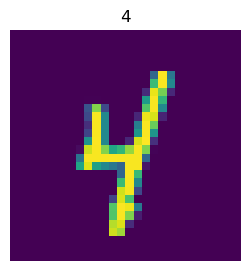

In [106]:
def plot_one(image,label):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

for image, label in train_dataset.take(1):
    plot_one(image,label)

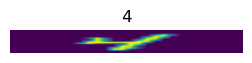

In [107]:
image = tf.cast(image, tf.float32)
image = tf.image.resize(image, [25, 256])
image = image / 255.0
plot_one(image,label)


In [108]:
# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

batch_size = 32
train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=10)


# Apply data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    return image, label

train_dataset = train_dataset.map(augment)

In [109]:
# Model prediction
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train the model
epochs=1
model.fit(train_dataset, epochs=epochs)

/media/data/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 [==============================] - 39s 26ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.9074


In [110]:
# # Make predictions
# predictions = model.predict(test_dataset)
# allpreds=predictions.flatten()
# allpnorms = np.where(allpreds > 0.5, 1, 0)

# alllabels=np.empty(0)
# for images, labels in test_dataset:
#     alllabels = np.append(alllabels, labels.numpy().flatten())

# score = metrics.accuracy_score(alllabels, allpnorms)
# print("Validation accuracy score: {}".format(score))

# collabels = pd.DataFrame(alllabels, columns=["l"])
# colpreds = pd.DataFrame( allpreds, columns=["pred"])
# pnorm = pd.DataFrame( allpnorms, columns=["pnorm"])
# diff = collabels["l"] - pnorm["pnorm"]

# compare = pd.concat([collabels, colpreds,pnorm,diff], axis=1)
# compare.columns = ["l", "pred", "pnorm","diff"]
# print(compare)

# compare.to_csv(OUTPUT_PATH + "pred_test_fit.csv", index=False)    

# # Save model
# timestr = time.strftime("%Y%m%d-%H%M%S")
# filename = f"acc_{score:.3f}_epochs_{epochs:.3f}_date_{timestr}.h5"
# fullpath = f"{OUTPUT_PATH}{filename}"
# print("Saving model to ", filename)
# model.save(fullpath)
